In [1]:
import torch

CONTENT_FILE = './input/boy/input_boy.wav'
STYLE_FILE = './input/girl/input_girl.wav'

learning_rate = 0.001

"""
L_D = L_{D, adv}
L_G = L_{G, adv} + alpha L_{G, id} + beta L_{(G, S), TraVeL}
L_S = beta L_{(G, S), TraVeL} + gamma L_{S, margin}
"""
alpha = 1.0 
beta = 10.0
gamma = 10.0

windowSize = 72       # the input width of the model
vecLen=128            #length of vector generated by siamese vector

hop=192               # hop size (window size = 6*hop)
sr=16000              #sampling rate
min_level_db=-100     #reference values to normalize data
ref_level_db=20

shape = 24              #length of time axis of split specrograms to feed to generator            

bs = 16               #batch size
delta = 2.            #constant for siamese loss

print_period = 100
max_epochs = 20
batch_size = 32

# If gpu is available
if torch.cuda.is_available():  
    device = torch.device('cuda')
else:
    device = torch.device('cpu')



# Reading

(77947,) (257, 609)
(94045,) (257, 735)
22050


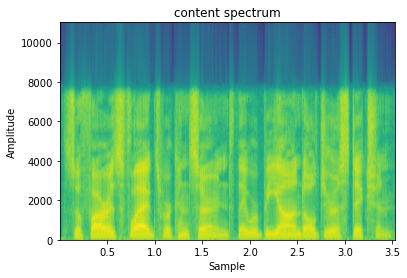

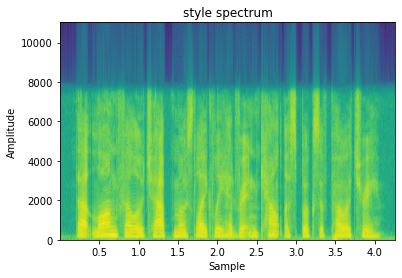

In [2]:
from utils import *
import torch

N_FFT = 512


x_content, sr = loadFile(CONTENT_FILE)
x_style, sr = loadFile(STYLE_FILE)

a_content = wav2spectrum(x_content, N_FFT)
a_style = wav2spectrum(x_style, N_FFT)

print(x_content.shape, a_content.shape)
print(x_style.shape, a_style.shape)
print(sr)

plot_spectrogram_with_raw_signal(x_content, sr, 'content spectrum')
plot_spectrogram_with_raw_signal(x_style, sr, 'style spectrum')


# Making Dataset

In [3]:
from torch.utils.data import Dataset, DataLoader
import numpy as np

class myDataset(Dataset):
    def __init__(self, content, style, size = 5000):
        self.style = []
        self.content = []
        W_S, H_S = style.shape
        W_C, H_C = content.shape 
        indices_C = np.random.randint(W_C - windowSize, size = size)
        indices_S = np.random.randint(W_S - windowSize, size = size)
        
        for i in indices_C:
            tensor = torch.tensor(content[None, :, i: i + windowSize])
            self.content.append(tensor)

        for i in indices_S:
            tensor = torch.tensor(style[None, :, i: i + windowSize])
            self.style.append(tensor)

    def __getitem__(self, index):
        return self.content[index], self.style[index]

    def __len__(self):
        return len(self.content)

dataset = myDataset(a_content, a_style)

train_loader = DataLoader(
    dataset, batch_size = batch_size
)


# Training 

In [4]:

import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from models import *
import torch 

# Crop function for training
def crop(x):
    WW = windowSize // 3
    return x[:, :, :, : WW], x[:, :, :, WW: WW * 2], x[:, :, :, WW * 2:]


model_S = Siamese(input_size = (1, 257, windowSize // 3), output_size = vecLen)
model_G = Generater(input_size = (1, 257, windowSize // 3))
model_D = Discriminator(input_size = (1, 257, windowSize))


optimizer = optim.Adam(
    list(model_S.parameters()) + list(model_G.parameters()) + list(model_D.parameters()),
    lr = learning_rate,
    weight_decay = 0.1
)


model_S.to(device)
model_G.to(device)
model_D.to(device)

model_S.train()
model_G.train()
model_D.train()

gupt = 3

losses, losses_D, losses_SG = [], [], []

for epoch in tqdm(range(max_epochs)):
    
    epoch_loss = 0.0
    epoch_D_loss = 0.0
    epoch_SG_loss = 0.0

    for i, (x, y) in enumerate(train_loader):
        
        x = x.to(device)
        y = y.to(device)

        x1, x2, x3 = crop(x)
        y1, y2, y3 = crop(y)

        if i % gupt == 0: # Train all

            optimizer.zero_grad()

            gen_x_1 = model_G(x1)
            gen_x_2 = model_G(x2)
            gen_x_3 = model_G(x3)
            
            gen_y_1 = model_G(y1)
            gen_y_2 = model_G(y2)
            gen_y_3 = model_G(y3)

            gen = torch.cat([gen_x_1, gen_x_2, gen_x_3], dim = -1)

            iden_gen = model_D(gen)
            iden_ori = model_D(y)

            siam_x_1_gen = model_S(gen_x_1)
            siam_x_2_gen = model_S(gen_x_3)

            siam_x_1 = model_S(x1)
            siam_x_2 = model_S(x3)


            # zero tensor
            zero = torch.zeros(vecLen, device = device)

            # identity mapping loss
            loss_id = (TraVeLGan.mae(y1, gen_y_1) + TraVeLGan.mae(y2, gen_y_2) + TraVeLGan.mae(y3, gen_y_3)) / 3.0

            # travel loss
            loss_m = TraVeLGan.loss_travel(siam_x_1, siam_x_1_gen, siam_x_2, siam_x_2_gen) + TraVeLGan.loss_siamses(siam_x_1, siam_x_2, zero, 2.0)

            # generator and critic losses
            loss_g = TraVeLGan.g_loss_f(iden_gen)
            loss_dr = TraVeLGan.d_loss_r(iden_ori, zero)
            loss_df = TraVeLGan.d_loss_f(iden_gen, zero)
            

            loss_D = (loss_dr + loss_df) / 2

            loss_GS = loss_g + alpha * loss_m + beta * loss_id

            loss = loss_D + loss_GS

            epoch_D_loss += loss_D.item()
            epoch_SG_loss += loss_GS.item()

            loss.backward()

            optimizer.step()


        else: # Train Critic only
            
            optimizer.zero_grad()

            gen_x_1 = model_G(x1)
            gen_x_2 = model_G(x2)
            gen_x_3 = model_G(x3)

            gen = torch.cat([gen_x_1, gen_x_2, gen_x_3], dim = -1)

            iden_gen = model_D(gen)
            iden_ori = model_D(y)

            # zero tensor
            zero = torch.zeros(vecLen, device = device)

            loss_dr = TraVeLGan.d_loss_r(iden_ori, zero)
            loss_df = TraVeLGan.d_loss_f(iden_gen, zero)

            loss = (loss_dr + loss_df) / 2.0

            epoch_D_loss += loss.item()

            loss.backward()

            optimizer.step()

    epoch_loss = epoch_SG_loss + epoch_D_loss

    losses.append(epoch_loss)
    losses_D.append(epoch_D_loss)
    losses_SG.append(epoch_SG_loss)


 95%|█████████▌| 19/20 [03:16<00:09,  9.79s/it]

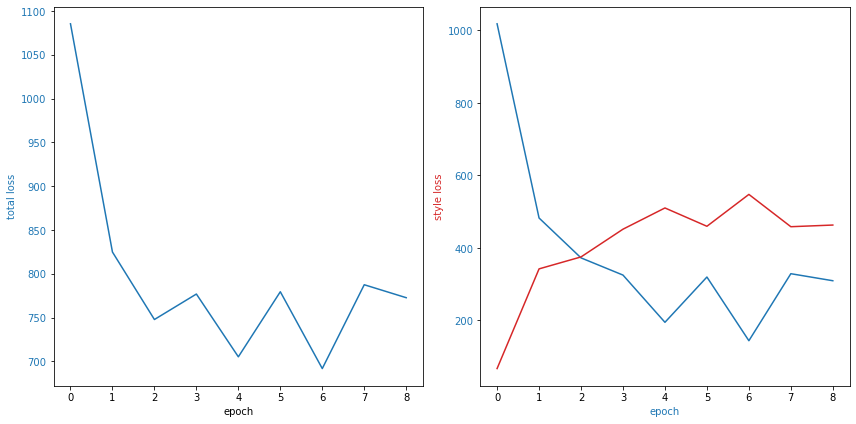

In [5]:

plot_curve(losses_D, losses_SG, losses)


# Save model

In [9]:
torch.save(model_S.state_dict(), './saved_model/TraVeLGan/model_S.pt')
torch.save(model_G.state_dict(), './saved_model/TraVeLGan/model_G.pt')
torch.save(model_D.state_dict(), './saved_model/TraVeLGan/model_D.pt')

# Load Model

In [10]:
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from models import *
import torch 

model_S = Siamese(input_size = (1, 257, windowSize // 3), output_size = vecLen)
model_G = Generater(input_size = (1, 257, windowSize // 3))
model_D = Discriminator(input_size = (1, 257, windowSize))


model_S.load_state_dict(torch.load('./saved_model/TraVelGan/model_S.pt'))
model_G.load_state_dict(torch.load('./saved_model/TraVelGan/model_G.pt'))
model_D.load_state_dict(torch.load('./saved_model/TraVelGan/model_D.pt'))


<All keys matched successfully>

# Generate output



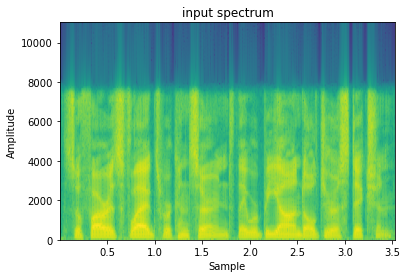

257 609
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


ParameterError: Audio buffer is not finite everywhere

In [11]:

from utils import *

INPUT_FILE = './input/boy/input_boy.wav'

N_FFT = 512


x_input, sr = loadFile(INPUT_FILE)
a_input = wav2spectrum(x_input, N_FFT)

plot_spectrogram_with_raw_signal(x_input, sr, 'input spectrum')


H, W = a_input.shape
print(H, W)

W_output = W - (W % windowSize) 
a_output = np.zeros((H, W_output))


# tensor_input = torch.transpose(torch.transpose(torch.tensor(a_input[:, :W_output]) ,1, 0).reshape(-1, 1, windowSize, H), -2, -1)
tensor_input = torch.tensor(a_input[:, :W_output])


model_G.to(device)
tensor_input = tensor_input.to(device)

for i in range(0, W_output, windowSize):
    a_output[:, i: i + windowSize] = model_G(tensor_input[:, i:i + windowSize].view(1, 1, H, windowSize)).detach().cpu().numpy()

# a_output = model_G(tensor_input).reshape(H, W_output).detach().cpu().numpy()

# a_output = np.where(a_output == np.inf, 1e9, a_output)
# a_output = np.where(a_output == np.nan, 1e9, a_output)

print(a_output)
x_output = spectrum2wav(a_output, N_FFT)


plot_spectrogram_with_raw_signal(x_output, sr, 'output spectrum')



# Save file

In [ ]:
import os

filename = 'TraVelGan.wav'

writeFile(os.path.join('./output/', filename), x_output, sr)
